In [1]:
import os, sys
import os.path as osp
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib.widgets import Button, Slider
from matplotlib.patches import Circle, Arc, Polygon
from copy import copy
import torch
import gc
import pandas as pd
# from torch_geometric.data import Dataset, Data, Batch
# from torch.utils.data import DataLoader
# from torch_geometric.utils import degree, add_self_loops
from commonroad.scenario.scenariocomplement import MultiFeatureExtractor, CoreFeatureExtractor0, NeighborFeatureExtractor0, NeighborFeatureExtractor, ScenarioWrapper

from commonroad.scenario.obstacle import StaticObstacle, ObstacleType, DynamicObstacle
from commonroad.common.file_reader_complement import LaneletCurveNetworkReader
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.lanelet import LineMarking, LaneletType
from commonroad.scenario.trajectorycomplement import FrenetState, Frenet, move_along_curve

from commonroad.scenario.laneletcomplement import *
from commonroad.visualization.draw_dispatch_cr import draw_object
from commonroad.scenario.laneletcomplement import make_lanelet_curve_network
from commonroad.common.file_reader import CommonRoadFileReader

sys.path.append('/home/boqi/Documents/Research/CooperativeDriving/')

import networkx as nx
from commonroad_env import GIDMReplayRoundabout, ReplayRoundabout
from config import Config 
from wurlitzer import pipes, sys_pipes, STDOUT, PIPE
# from motion_predictor import FrenetPathMultiTargetGCN, get_dtypes
from policy import RulebasedPolicy
from sklearn.model_selection import train_test_split

%load_ext wurlitzer

# checkpoint = torch.load("./model/FTT-train_lr-0.001_decay-0.9999_L2-0.0_bs-16-/checkpoint_20000.pt")
# model = FrenetPathMultiTargetGCN(Config["rounD"])
# long_dtype, float_dtype = get_dtypes()
# model.type(float_dtype).eval()
# model.load_state_dict(checkpoint['best_state_dict'])

In [2]:
env = GIDMReplayRoundabout(Config["rounD"], motion_predictor=None)
# env = GIDMReplayRoundabout(Config["rounD"], motion_predictor=model)

In [3]:
data_root_dir = Config["rounD"]["data_dir"]
data_files = [osp.join(data_root_dir, "processed", d) for d in  os.listdir(osp.join(data_root_dir, "processed")) if 'data' in d]


In [4]:
data_file = data_files[0]
splited_name = data_file.split("_")
traj = torch.load(data_file)
#traj.veh_t = traj.veh_t + 160
traj_idx = int(splited_name[1])
file_num = int(splited_name[-1][:-3])
egoid = int(traj.veh_id.numpy()[0])
s = env.reset((traj, traj_idx), egoids_list=[egoid])

In [5]:
ego = env.ego_vehicles[egoid]
policy = RulebasedPolicy(Config["rounD"], env.ego_vehicles[egoid], env)

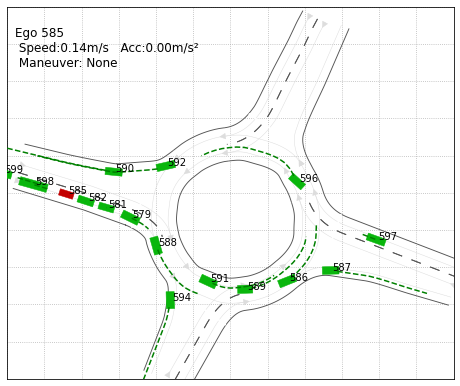

In [6]:
env.render(h=8,w=8, fill_lanelet=False, show_annotation=False, show_prediction=True, show_planned_trajectories=False)


In [8]:
obs, obs_preds = {}, {}
for obs_id, ob in env.obstacles[env.time_step].items():
    if obs_id == egoid:
        continue 
    if obs_id in env.background_vehicles and env.background_vehicles[obs_id].front_vehid == egoid:
        continue 
    if obs_id in env.background_vehicles and env.background_vehicles[obs_id].merge_front_vehid == egoid:
        continue 
    obs[obs_id] = ob 
    if obs_id in env.obstacles_preds[env.time_step]:
        obs_preds[obs_id] = env.obstacles_preds[env.time_step][obs_id]
if env.motion_predictor is None:
    obs_preds = None
action = policy.action(obs, obs_preds)

Ego arrived:  False


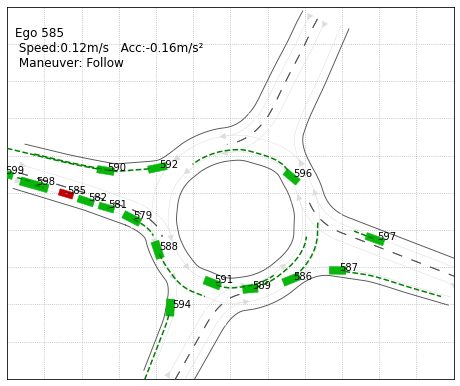

In [9]:
env.step({egoid:action})
print("Ego arrived: ", env.ego_vehicles[egoid].arrived)
env.render(h=8,w=8, fill_lanelet=False, show_annotation=False, show_prediction=True, show_planned_trajectories=True)
